# Modelo 5 para pruebas

## Importacion de librerias

In [ ]:
import os, time, datetime
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50 # type: ignore
from tensorflow.keras import layers, models # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from tensorflow.keras.metrics import AUC, F1Score # type: ignore
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array # type: ignore
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers.schedules import ExponentialDecay # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.regularizers import l2 # type: ignore
from tensorflow.keras.callbacks import TensorBoard # type: ignore

## Clase que carga y redimensiona las imagenes a un formato que pueda procesar el modelo

- Se cargan las imagenes de ambos datasets (Plaga, Sana), donde se va agregando a un array con su respectiva etiqueta segun el nombre de cada carpeta


In [4]:
class ImageDataset:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.images = []
        self.labels = []

    def load_data(self):
        for label in ['plaga', 'sana']:
            label_dir = os.path.join(self.data_dir, label)
            for image_name in os.listdir(label_dir):
                img_path = os.path.join(label_dir, image_name)
                img_array = self.load_and_preprocess_image(img_path)
                if img_array is not None:
                    self.images.append(img_array)
                    self.labels.append(self.assign_label(label))

    def load_and_preprocess_image(self, img_path):
        try:
            img = load_img(img_path, target_size=(224, 224))  # Redimensionar
            img_array = img_to_array(img) / 255.0  # Normalizar
            return img_array
        except OSError as e:
            print(f"Error al cargar la imagen {img_path}: {e}")
            return None

    def assign_label(self, label):
        return 1 if label == 'plaga' else 0  # Etiquetas binarias

## Creacion del modelo

- Se esta usando ResNet50 como modelo base ya es algo que fue entrenado previamente para la extraccion de caracteristicas y nos ayudara para la identificacion de la plaga
- Planteamos un dropout de 0.3 (30%) para no ser tan agresivos al apagar las neuronas para el entrenamiento
- En este caso ampliamos lo que es el embudo del modelo ya que partimos de una capa densa y vamos reduciendo desde 512 a luego pasar a 256, luego 128, le sigue 64 y por ultimo 1 neurona con activacion sigmoide para clasificacion binaria


In [ ]:
class ResNetModel:
    def __init__(self):
        """Usamos ResNet50 como base y agregamos capas de salida."""
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


        for layer in base_model.layers[-15:]:
            layer.trainable = True
        
        
        self.model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),  # Promedio global de las características
            layers.Dropout(0.3),
            layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
            layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
            layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
            layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
            layers.Dense(1, activation='sigmoid')  # Salida binaria (plaga o sana)
        ])
        
    

    def compile(self):
        """Compila el modelo."""
        
        lr_schedule = ExponentialDecay(
            initial_learning_rate=0.001, #Valor inicial del learning rate
            decay_steps=50000,  # Número de pasos antes de reducir el learning rate
            decay_rate=0.96,     # Factor de reducción en cada paso
            staircase=True       # Si se debe hacer el descenso en "escalones"
        )
        
        optimizer = Adam(learning_rate=lr_schedule) # Usamos Adam con un scheduler de decaimiento exponencial
        
        self.model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', AUC(), F1Score()]) 

    def train(self, X_train, y_train, X_val, y_val, epochs=6, batch_size=32):
        """Entrena el modelo con data augmentation.""" 

        
        # Early stopping
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )

        log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

        print("Iniciando el entrenamiento del modelo...")
        history = self.model.fit(
            X_train,
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping, tensorboard_callback],
            verbose=1
        )
        
        return history


    def evaluate(self, X_val, y_val):
        """Evalúa el modelo con los datos de validación."""
        loss, accuracy, auc, f1 = self.model.evaluate(X_val, y_val)
        print(f'Pérdida: {loss}, Accuracy: {accuracy}, AUC: {auc}, F1-Score: {f1}')
        return loss, accuracy, auc, f1

    def save(self, model_name='modelo_entrenado_resnet.h5'):
        """Guarda el modelo entrenado."""
        self.model.save(model_name)

        
        


## Compilacion y carga de datos

- Se cargo el dataset y se dividio en un 80/20 (80% para el entrenamiento y 20% para la validacion)
- Se expandio una dimension a los datos para que pueda ser medido por la metrica de f1-score

In [6]:
data_dir = 'data/'  # Cambia a la ruta de tus imágenes
dataset = ImageDataset(data_dir)
dataset.load_data()

# Convertir listas a arrays de NumPy
images = np.array(dataset.images)
labels = np.array(dataset.labels)


# Dividir las imágenes en entrenamiento (80%) y validación (20%)
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Agregar una dimensión adicional para la metrica de f1-score 
y_train  = np.expand_dims(y_train, axis=-1)
y_val = np.expand_dims(y_val, axis=-1) 

#print("Clases en train:", np.bincount(y_train))
#print("Clases en val:", np.bincount(y_val))

print(y_train.shape)  # → (2466,)
print(y_val.shape)    # → (617,)


(2466, 1)
(617, 1)


## Entrenamiento del modelo

- Estamos usando 100 epocas para el entrenamiento pero usamos un early stopping

In [7]:
# Crear y entrenar el modelo
model = ResNetModel()
model.compile()
print("Compilando el modelo...")
history = model.train(X_train, y_train, X_val, y_val, epochs=100)

# Evaluar el modelo
loss, accuracy, auc, f1 = model.evaluate(X_val, y_val)

Compilando el modelo...
Iniciando el entrenamiento del modelo...
Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 800s 9s/step - accuracy: 0.8875 - auc: 0.9554 - f1_score: 0.6817 - loss: 1.5471 - val_accuracy: 0.4684 - val_auc: 0.5000 - val_f1_score: 0.0000e+00 - val_loss: 501.5899
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 630s 8s/step - accuracy: 0.9440 - auc: 0.9851 - f1_score: 0.6818 - loss: 0.7917 - val_accuracy: 0.5316 - val_auc: 0.3911 - val_f1_score: 0.6942 - val_loss: 1.5866
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 632s 8s/step - accuracy: 0.9472 - auc: 0.9890 - f1_score: 0.6841 - loss: 0.4804 - val_accuracy: 0.5316 - val_auc: 0.8653 - val_f1_score: 0.6942 - val_loss: 0.9143
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 635s 8s/step - accuracy: 0.9679 - auc: 0.9946 - f1_score: 0.6745 - loss: 0.2979 - val_accuracy: 0.5316 - val_auc: 0.5000 - val_f1_score: 0.6942 - val_loss: 11.5631
Epoch 5/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 626s 8s/step - accuracy: 0.9673 - auc: 0.9941 - f1_score: 0.7164 - loss: 0.2341 -

## Obtencion de predicciones

- Obtenemos las predicciones del modelo y lo pasamos a etiquetas binarias para nuestra matris de confusion

In [8]:
# Obtener predicciones como probabilidades
y_pred_probs = model.model.predict(X_val)

# Convertir probabilidades a etiquetas binarias
y_pred_classes = (y_pred_probs >= 0.5).astype(int)

y_val = np.expand_dims(y_val, axis=-1)  # → (617, 1)
y_val_flat = y_val.flatten()


20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step


- Aca se genera la matris de confusion donde se puede apreciar que es un buen modelo y tiene una buena precision al diferenciar las clases que son plaga y sana

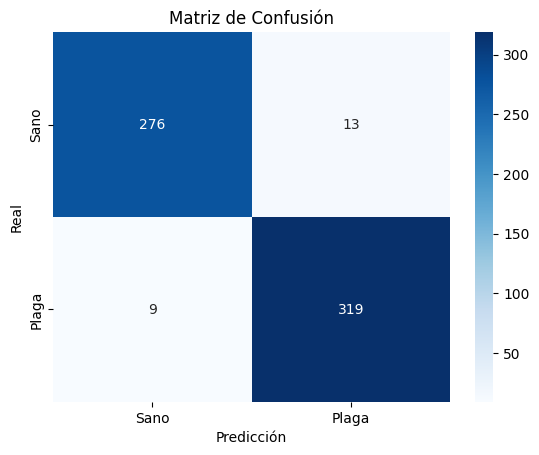

              precision    recall  f1-score   support

        Sano       0.97      0.96      0.96       289
       Plaga       0.96      0.97      0.97       328

    accuracy                           0.96       617
   macro avg       0.96      0.96      0.96       617
weighted avg       0.96      0.96      0.96       617



In [9]:
import seaborn as sns

cm = confusion_matrix(y_val_flat, y_pred_classes)

# Visualización
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sano', 'Plaga'], yticklabels=['Sano', 'Plaga'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

# Reporte detallado
print(classification_report(y_val_flat, y_pred_classes, target_names=['Sano', 'Plaga']))

## Testeo

- Aca escogemos un numero de imagenes (10) aleatorias de nuestro conjunto de validacion y lo pasamos al modelo para que lo evalua y haga la prediccion

20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step


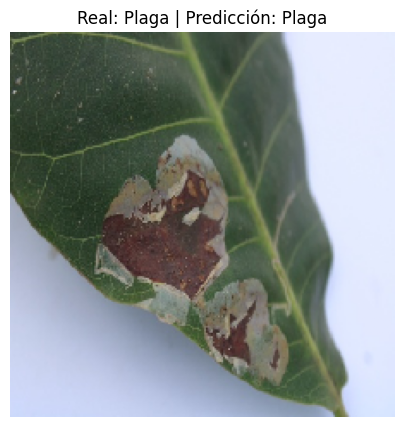

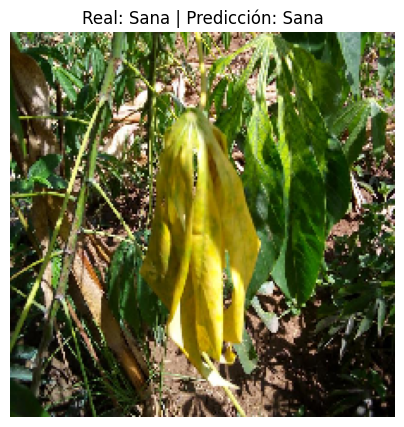

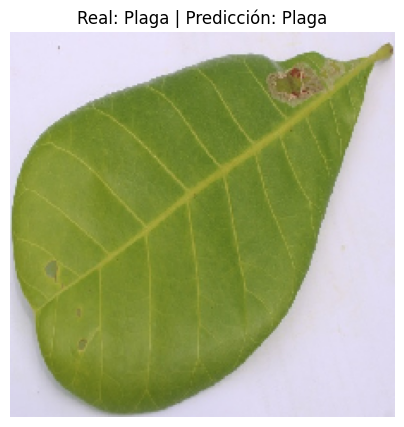

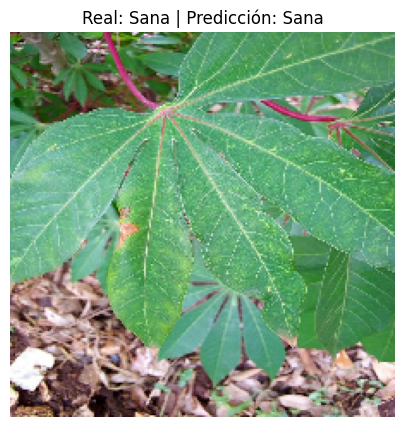

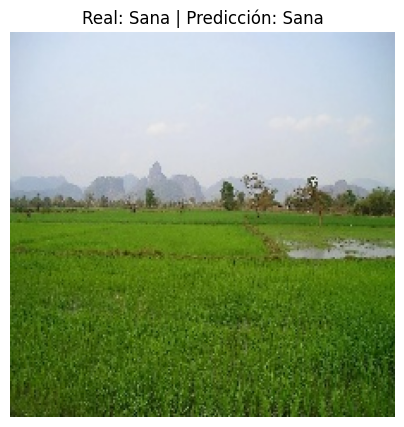

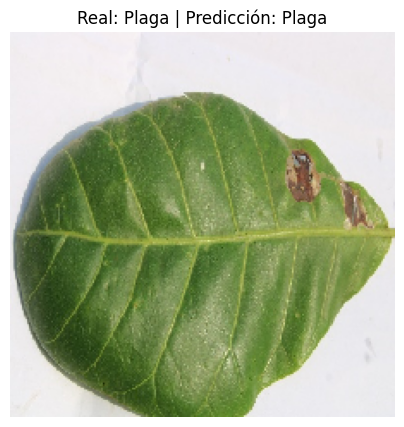

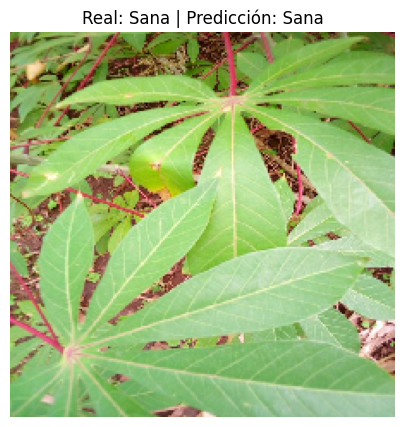

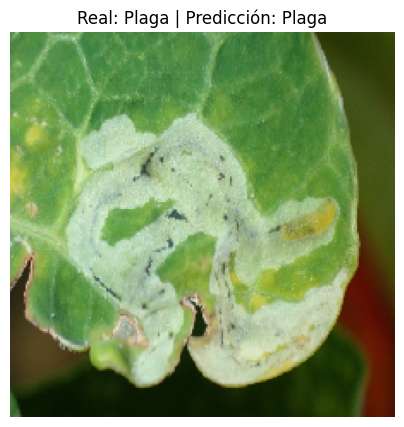

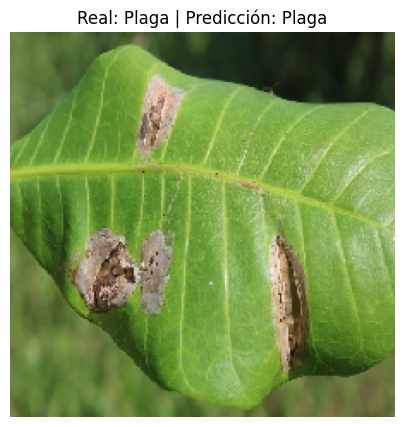

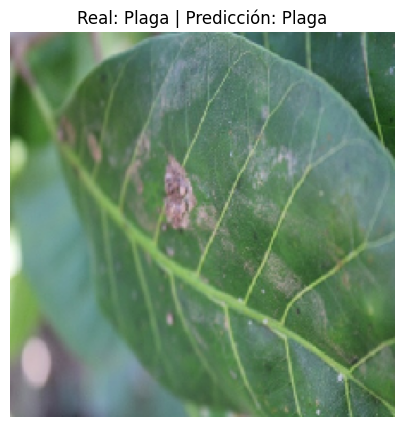

In [ ]:
predictions = model.model.predict(X_val)  # Obtener las predicciones del modelo


random_indices = np.random.choice(len(X_val), size=10, replace=False) 

# Mostrar las imágenes seleccionadas aleatoriamente
for i in random_indices:
        img = X_val[i]  # Imagen de validación
        label = 'Plaga' if y_val[i] == 1 else 'Sana'  # Etiqueta real
        pred = 'Plaga' if predictions[i] > 0.5 else 'Sana'  # Predicción del modelo
        
        # Mostrar la imagen
        plt.figure(figsize=(5, 5))
        plt.imshow(img)  # Mostrar la imagen
        plt.axis('off')  # Sin ejes
        plt.title(f"Real: {label} | Predicción: {pred}")
        plt.show()


## Graficos para las metricas

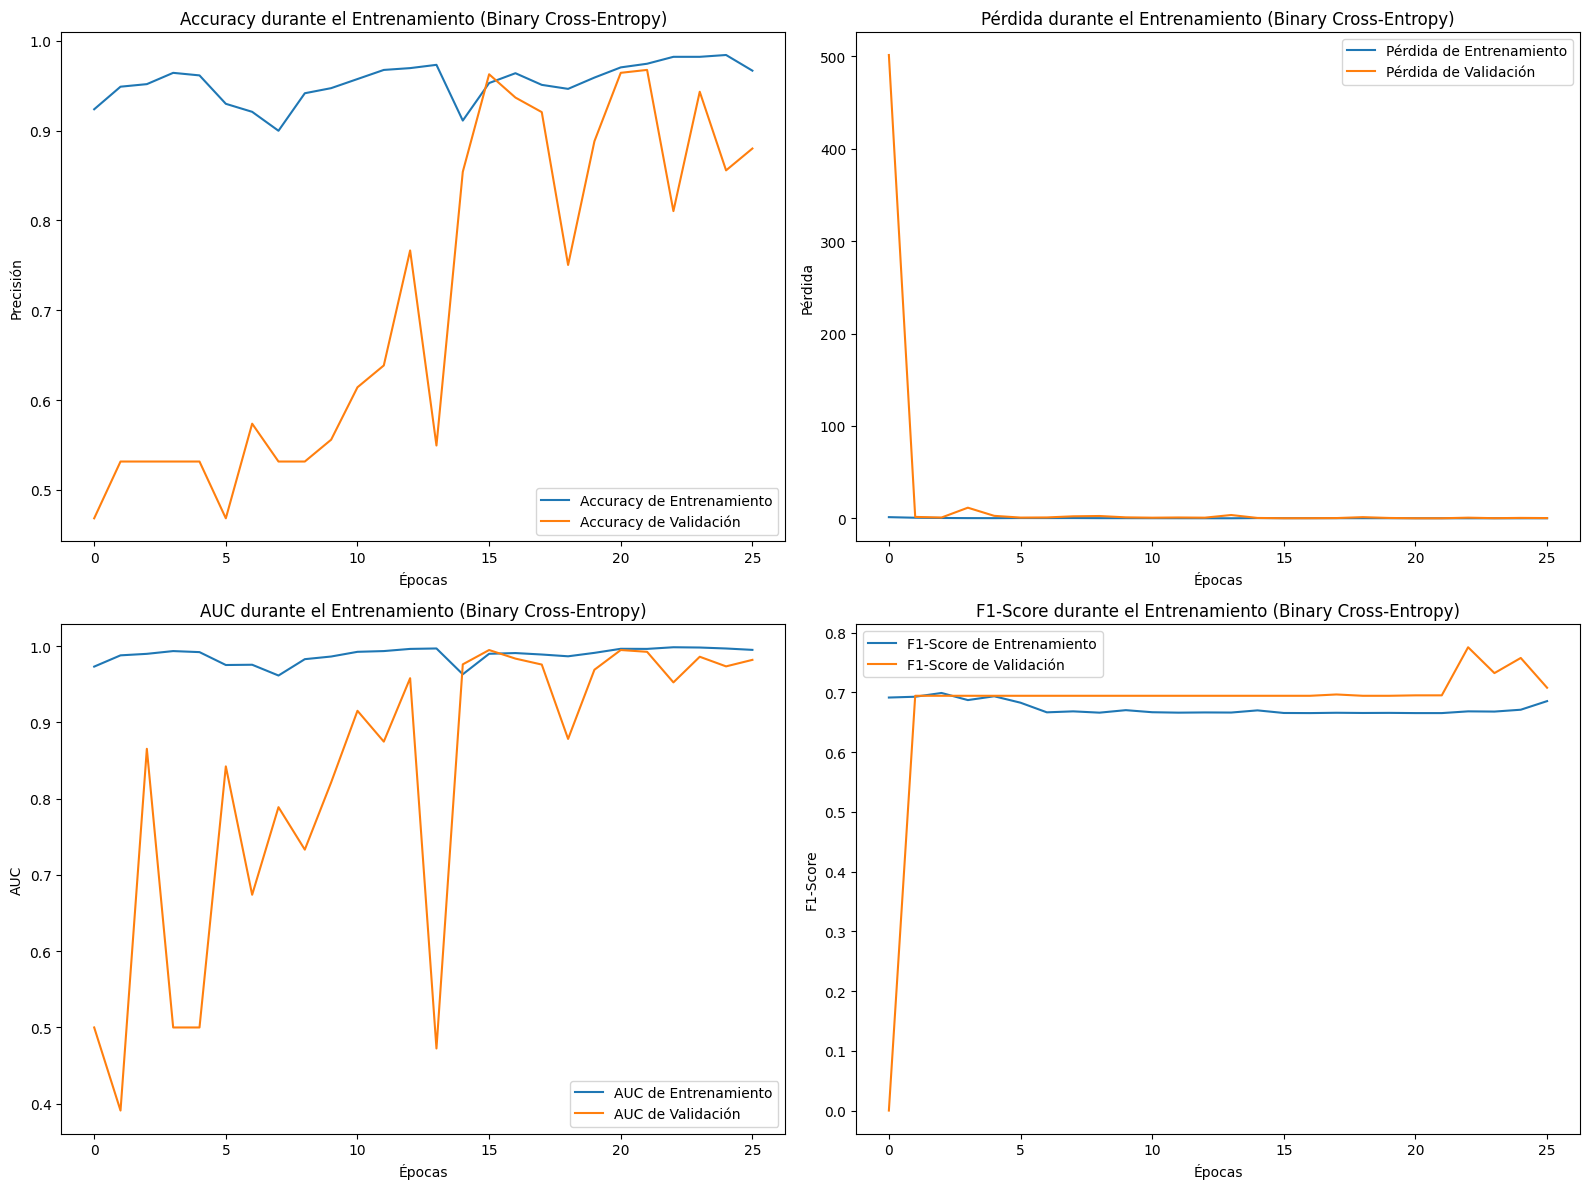

In [10]:
import matplotlib.pyplot as plt

def plot_training_history(history, loss_name):
    # Graficar la evolución de las métricas durante el entrenamiento
    plt.figure(figsize=(16, 12))

    # Accuracy durante el entrenamiento
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy de Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Accuracy de Validación')
    plt.title(f'Accuracy durante el Entrenamiento ({loss_name})')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    # Pérdida durante el entrenamiento
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de Validación')
    plt.title(f'Pérdida durante el Entrenamiento ({loss_name})')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    # AUC durante el entrenamiento
    plt.subplot(2, 2, 3)
    plt.plot(history.history['auc'], label='AUC de Entrenamiento')
    plt.plot(history.history['val_auc'], label='AUC de Validación')
    plt.title(f'AUC durante el Entrenamiento ({loss_name})')
    plt.xlabel('Épocas')
    plt.ylabel('AUC')
    plt.legend()

    # F1-Score durante el entrenamiento
    plt.subplot(2, 2, 4)
    plt.plot(history.history['f1_score'], label='F1-Score de Entrenamiento')
    plt.plot(history.history['val_f1_score'], label='F1-Score de Validación')
    plt.title(f'F1-Score durante el Entrenamiento ({loss_name})')
    plt.xlabel('Épocas')
    plt.ylabel('F1-Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Graficar el historial de entrenamiento
plot_training_history(history, "Binary Cross-Entropy")
